In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u
from sklearn.cluster import HDBSCAN

In [11]:
class fit_obj:

    """
    class to handle multiple SDSS fits files and perform ML analysis on them
    """


    def __init__(self, fits_glob):
        self.fits_files=glob.glob(fits_glob)
        self.spec_data=[]
        self.spec_header=[]
        

    def load_fits_data(self):
        print(self.fits_files)
        for i in self.fits_files:
            with fits.open(i) as fit_file:
                specdata=fit_file[1].data
                specheader=fit_file[0].header
                self.spec_data.append(specdata)
                self.spec_header.append(specheader)

    def show_header(self):
        for i in self.spec_header:
            print("\n")
            print(i)
    
    def spec_rearrange(self):

        #Get the shapes of each spectra then find the smallest shape along 0 axis
        spec_shape_list=[]
        for i in self.spec_data:
            print(i.shape)
            spec_shape_list.append(i.shape)

        spec_shape_list=np.array(spec_shape_list)
        smallest_spec=np.min(spec_shape_list)

        #Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
        #to last lambda, as in some spectra the measurements start from different first to different last lambda
        spectra_filtered_list=[]
        for i in self.spec_data:
            spec=i
            #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
            mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
            filtered_data = spec[mask]
            spectra_filtered_list.append(filtered_data)
        #And here we have a np array containing individual spectras
        self.spectra_filtered_list=np.array(spectra_filtered_list)
        print('After realigning the spectra wrt halpha wavelenght')
        print(self.spectra_filtered_list.shape)

    def decision_tree_sky_model(self):
        spectra_filtered_list_sky_array=np.array(self.spectra_filtered_list['sky'])
        
        wavebins = spectra_filtered_list_sky_array.shape[1]
        num_spectra = spectra_filtered_list_sky_array.shape[0]
        master_sky_spectrum = np.zeros(wavebins)

        # Running over each intensity value at a wavebin
        for i in range(wavebins):
            # Intensities for the i-th wavelength bin for all fibres
            flux_at_wavebin = spectra_filtered_list_sky_array[:, i]
            fibres=np.arange(num_spectra).reshape(-1,1)
            regressor = DecisionTreeRegressor(max_depth=3)  
            regressor.fit(fibres, flux_at_wavebin)  
            pred_values = regressor.predict(fibres)
            master_sky_spectrum[i] = pred_values.mean()

        print("Generated Master Sky Spectrum:", master_sky_spectrum)

        #scaling the master sky to the science spectra
        ref_master= master_sky_spectrum[3600:3750]
        ref_sky=spectra_filtered_list_sky_array[:,3600:3750]
        scaling=np.mean(ref_sky/ref_master)
        master_scaled= master_sky_spectrum[0]*scaling


        #Subtract the master from one of the fibers to get residuals
        sub=master_scaled- spectra_filtered_list_sky_array[1]
        #Convert to flux units
        sub_flux = sub* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
        sky_flux=self.spectra_filtered_list['sky'][1]* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
        master_sky_flux=master_sky_spectrum* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
        
        
        fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(10,7))
        ax[0].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA,
                   sub_flux, label='residual (sub from master sky)')
        ax[0].legend()
        #Convert to flux units
        ax[1].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA, 
                   sky_flux, label='sky')
        ax[1].legend()
        ax[2].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA, 
                   master_sky_flux, label='master_sky from DTR')
        ax[2].legend()
        ax[0].set_title('Effects of Decison Tree for master sky from {0} fibres'.format(self.spectra_filtered_list.shape[0]))

 
    def fibre_correlation_plot(self, fibre_1, fibre_2):
        self.fibre_1=fibre_1
        self.fibre_2=fibre_2
        plt.figure(figsize=(5,5))
        plt.scatter( self.spectra_filtered_list[self.fibre_1]['sky'], 
                    self.spectra_filtered_list[self.fibre_2]['sky'], marker='.')
        plt.yscale('log')
        plt.xscale('log')
        plt.title('Correlation among multiple fibres')
    


    def hdbscan_skylines_detection(self):

        cluster_array=np.array([self.spectra_filtered_list[self.fibre_1]['sky'], 
                                self.spectra_filtered_list[self.fibre_2]['sky']]).T   
        cluster= HDBSCAN(min_cluster_size=20, min_samples=20)
        cluster.fit( cluster_array  )
         
        plt.scatter(cluster_array[:,0],cluster_array[:,1], marker='.', c= cluster.labels_)
        plt.yscale('log')
        plt.xscale('log')
                    
        labels=cluster.labels_
        plt.figure(figsize=(5,5))
        flux= cluster_array[:,0]
        wave=np.arange(len(flux))
        plt.scatter(wave, flux, c=cluster.labels_, marker='*')

        discard_label= labels==-1
        cluster_array[discard_label,:]=np.nan

        plt.figure(figsize=(10,2))
        plt.plot(cluster_array[:,0])

        plt.figure(figsize=(10,4))

        plt.plot(self.spectra_filtered_list[self.fibre_2]['flux'])
        plt.plot(cluster_array[:,1])


                           

['spec-1678-53433-0001.fits', 'spec-1678-53433-0425.fits', 'spec-0548-51986-0020.fits', 'spec-0548-51986-0001.fits']
(3822,)
(3846,)
(3828,)
(3769,)
After realigning the spectra wrt halpha wavelenght
(4, 3751)
Generated Master Sky Spectrum: [ 8.88730168  8.13434225  7.63666338 ... 45.70083046 14.90502095
  5.31311858]


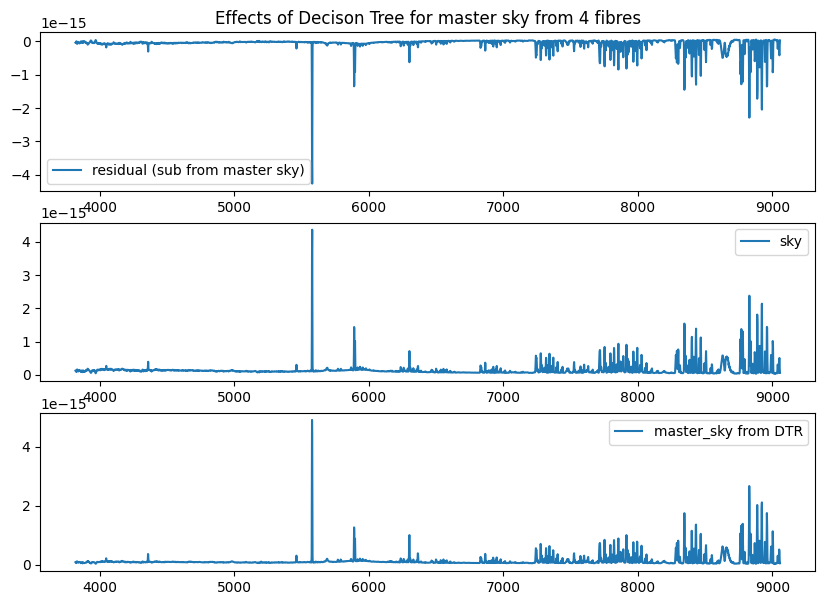

In [12]:
my_fits=fit_obj('*.fits')

my_fits.load_fits_data()

my_fits.spec_rearrange()
my_fits.decision_tree_sky_model()



